In [1]:
import pandas as pd
import numpy as np
# Load local .csv file as DataFrame
df = pd.read_csv('mcd_merge.csv')
# Inspect the data

df['Date'] = df['Datetime'].str[:-6]
df['Date']=pd.to_datetime(df["Date"]).dt.strftime("%Y-%m-%d %H:%M:%S")

data_date = df.filter(['Date'])

data_date = data_date.values
# Get the number of rows to train the model on
training_data_date = int(np.ceil( len(data_date) * .95 ))

from sklearn.preprocessing import MinMaxScaler

# Create the scaled training data set
train_data_date = data_date[0:int(training_data_date), :]

# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.56458207, 0.5641259 , 0.57197607, 0.57987219, 0.57827458,
       0.57873074, 0.57416703, 0.57804615, 0.57599238, 0.57485163,
       0.57188483, 0.56823345, 0.56663584, 0.55682314, 0.55408477,
       0.55545395, 0.54815119, 0.54130528, 0.53263333, 0.5248744 ,
       0.51939767, 0.52441824, 0.53035113, 0.53217717, 0.52898194,
       0.52122302, 0.52692817, 0.53308949, 0.54404364, 0.54187565,
       0.53354635, 0.55134641, 0.56047452, 0.57325401, 0.56640811,
       0.57827458, 0.56366905, 0.5595615 , 0.5618437 , 0.56047452,
       0.56672707, 0.56047452, 0.56321288, 0.56047452, 0.56093068,
       0.56001836, 0.56275672, 0.56229986, 0.56376097, 0.55819232,
       0.54952037, 0.55317175, 0.56344131, 0.56458207, 0.56229986,
       0.55317175, 0.55088955, 0.55864918, 0.55499779, 0.56823345])]
[0.5750793582256062]

[array([0.56458207, 0.5641259 , 0.57197607, 0.57987219, 0.57827458,
       0.57873074, 0.57416703, 0.57804615, 0.57599238, 0.57485163,
       0.57188483, 0.56823345, 0.566

In [5]:
#cnn-lstm

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
from numpy import array

# Build the LSTM model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=1, activation='tanh', input_shape= (x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=True, activation='tanh' ))
model.add(Flatten())
model.add(Dense(1, activation='relu'))
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=adam, loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=8)
model.summary()

Epoch 1/8
104/104 [==============================] - 6s 26ms/step - loss: 0.0103
Epoch 2/8
104/104 [==============================] - 3s 26ms/step - loss: 0.0013
Epoch 3/8
104/104 [==============================] - 3s 27ms/step - loss: 0.0011
Epoch 4/8
104/104 [==============================] - 3s 32ms/step - loss: 9.0128e-04
Epoch 5/8
104/104 [==============================] - 3s 27ms/step - loss: 7.4972e-04
Epoch 6/8
104/104 [==============================] - 3s 27ms/step - loss: 6.6511e-04
Epoch 7/8
104/104 [==============================] - 3s 26ms/step - loss: 5.3756e-04
Epoch 8/8
104/104 [==============================] - 3s 27ms/step - loss: 5.0109e-04
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 60, 32)            64        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 30, 32)  

In [6]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions3 = model.predict(x_test)
predictions3 = scaler.inverse_transform(predictions3)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions3 - y_test) ** 2)))
rmse

0.4114383782198133

In [7]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

train = data[:training_data_len]
valid_3 = data[training_data_len:]
valid_3['Predictions3'] = predictions3

mape(valid_3['Close'], valid_3['Predictions3'])

<ipython-input-7-cda6690b5d4b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_3['Predictions3'] = predictions3


0.1245174559873437

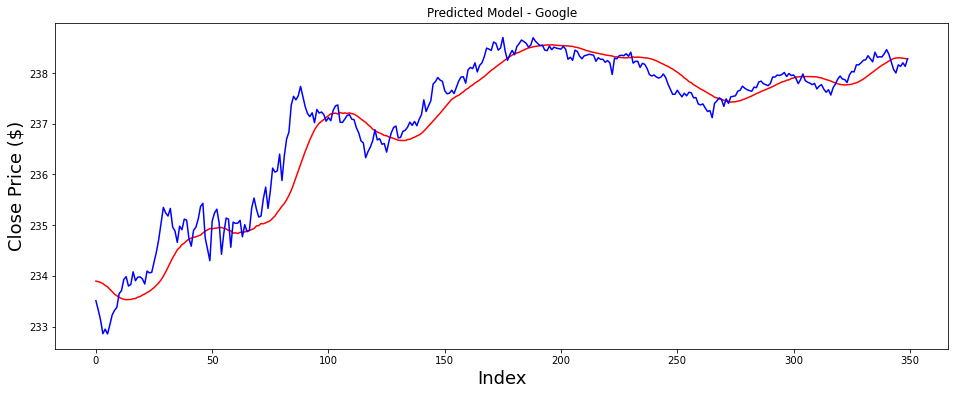

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.title('Predicted Model - Google')
plt.xlabel('Index', fontsize=18)
plt.ylabel('Close Price ($)', fontsize=18)
#plt.plot(train['Close'], 'b-', label = 'train')
plt.plot(predictions3,'r-', label = 'predict')
plt.plot(y_test,'b-', label = 'actual')
#plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()